In notebook **3_build_model**, we let all the weights of the resnet model be updated when fine tuning on the EuroSAT dataset. One other way to finetune would be to only modify the weights of the final fully connected layer and freeze the other weights.

Steps:
1. Load resnet50 model
2. Load train,val,test data
3. Freeze all except the final fully connected layer
4. Train the model
5. Get performance on test data

In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from torchvision import models
from torchvision import datasets
import torchsummary

In [2]:
model = models.efficientnet_b0(weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 34.8MB/s]


In [3]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


In [4]:
model = model.to(device)

In [5]:
torchsummary.summary(model,input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [6]:
# #If running from colab
from google.colab import drive
drive.mount('/content/drive')

data_folder = '/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/data'

!cp  -r '/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/data' 'data/' #very important for high
#speed of training, else training becomes too slow if each batch of data has to be fetched 🤯
#from drive https://stackoverflow.com/questions/60798910/google-colab-pro-gpu-running-extremely-slow

data_folder = '/content/data/'

Mounted at /content/drive


In [ ]:
#If running locally
# data_folder = 'data/data/'

In [7]:
dataset = datasets.ImageFolder(os.path.join(data_folder, 'EuroSAT','2750'))

In [8]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

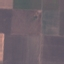

In [9]:
dataset[0][0]

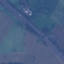

In [10]:
dataset[10000][0]

In [11]:
from torch.utils import data

In [12]:
class EuroSAT(data.Dataset):
    def __init__(self,dataset,transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self,index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x,y

    def __len__(self):
        return len(dataset)


In [13]:
train_loader = torch.load(os.path.join(data_folder,'train_loader.pth'))
val_loader = torch.load(os.path.join(data_folder,'val_loader.pth'))
test_loader = torch.load(os.path.join(data_folder,'test_loader.pth'))

<ipython-input-13-0b32d987e57a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load(os.path.join(data_folder,'train_loader.pth'))
<ipython-input-13-0b

In [14]:
model = model.to(device)

In [15]:
torchsummary.summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

In [16]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [17]:
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features,len(dataset.classes))

In [18]:
model = model.to(device)

In [19]:
torchsummary.summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [20]:
lr = 0.001
epochs = 10

In [21]:
optimizer = torch.optim.SGD(model.parameters(),lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [22]:
def train(model,dataloader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    running_total_correct = 0.0

    for i,(inputs,labels) in enumerate(tqdm.tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs,labels)

        loss.backward()

        optimizer.step()

        _,preds = torch.max(outputs,1)

        running_loss += loss.item() *inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct /  len(dataloader.dataset)) * 100
    print(f'Train loss : {epoch_loss:.2f};Accuracy : {epoch_accuracy:.2f}')

    return epoch_loss, epoch_accuracy

In [23]:
def evaluate(model,dataloader,criterion,phase='val'):
    model.eval()

    running_loss = 0.0
    running_total_correct = 0.0

    for i,(inputs,labels) in enumerate(tqdm.tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _, preds = torch.max(outputs,1)

        running_loss += loss.item() * inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
    print(f'{phase.title()} Loss = {epoch_loss:.2f}; Accuracy = {epoch_accuracy:.2f}')

    return epoch_loss,epoch_accuracy

In [24]:
def fit(model,train_loader,val_loader,n_epochs,lr,criterion,optimizer):
    best_loss = np.inf
    best_model = None

    for epoch in range(n_epochs):
        print(f'Epoch : {epoch+1}')
        train(model,train_loader,criterion,optimizer)
        val_loss,_ = evaluate(model,val_loader,criterion)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

    return best_model

In [25]:
best_model = fit(model = model,
                 train_loader = train_loader,
                 val_loader = val_loader,
                 n_epochs = epochs,
                 lr = lr,
                 criterion = criterion,
                 optimizer = optimizer
                 )

Epoch : 1


100%|██████████| 1182/1182 [01:57<00:00, 10.05it/s]


Train loss : 1.72;Accuracy : 52.14


100%|██████████| 254/254 [00:13<00:00, 18.88it/s]


Val Loss = 1.18; Accuracy = 72.89
Epoch : 2


100%|██████████| 1182/1182 [01:55<00:00, 10.24it/s]


Train loss : 1.03;Accuracy : 71.02


100%|██████████| 254/254 [00:12<00:00, 20.25it/s]


Val Loss = 0.78; Accuracy = 83.01
Epoch : 3


100%|██████████| 1182/1182 [01:55<00:00, 10.27it/s]


Train loss : 0.80;Accuracy : 75.42


100%|██████████| 254/254 [00:11<00:00, 21.75it/s]


Val Loss = 0.47; Accuracy = 87.43
Epoch : 4


100%|██████████| 1182/1182 [01:55<00:00, 10.27it/s]


Train loss : 0.68;Accuracy : 78.56


100%|██████████| 254/254 [00:12<00:00, 20.36it/s]


Val Loss = 0.36; Accuracy = 90.17
Epoch : 5


100%|██████████| 1182/1182 [01:53<00:00, 10.40it/s]


Train loss : 0.59;Accuracy : 81.38


100%|██████████| 254/254 [00:12<00:00, 20.57it/s]


Val Loss = 0.28; Accuracy = 92.10
Epoch : 6


100%|██████████| 1182/1182 [01:54<00:00, 10.36it/s]


Train loss : 0.55;Accuracy : 82.26


100%|██████████| 254/254 [00:12<00:00, 20.51it/s]


Val Loss = 0.25; Accuracy = 92.77
Epoch : 7


100%|██████████| 1182/1182 [01:53<00:00, 10.38it/s]


Train loss : 0.50;Accuracy : 83.94


100%|██████████| 254/254 [00:10<00:00, 23.94it/s]


Val Loss = 0.21; Accuracy = 93.93
Epoch : 8


100%|██████████| 1182/1182 [01:54<00:00, 10.35it/s]


Train loss : 0.46;Accuracy : 85.11


100%|██████████| 254/254 [00:13<00:00, 19.11it/s]


Val Loss = 0.23; Accuracy = 93.26
Epoch : 9


100%|██████████| 1182/1182 [01:53<00:00, 10.39it/s]


Train loss : 0.44;Accuracy : 85.52


100%|██████████| 254/254 [00:10<00:00, 23.27it/s]


Val Loss = 0.17; Accuracy = 94.96
Epoch : 10


100%|██████████| 1182/1182 [01:54<00:00, 10.31it/s]


Train loss : 0.43;Accuracy : 86.00


100%|██████████| 254/254 [00:13<00:00, 19.10it/s]

Val Loss = 0.17; Accuracy = 94.64


In [26]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

100%|██████████| 254/254 [00:12<00:00, 20.57it/s]

Test Loss = 0.17; Accuracy = 94.94


Let's visualize some predictions

In [27]:
inputs, labels = next(iter(test_loader))

inputs = inputs.to(device)
labels = labels.to(device)

with torch.set_grad_enabled(False):
  outputs = best_model(inputs)
  loss = criterion(outputs, labels)
  _, preds = torch.max(outputs, 1)

In [28]:
labels

tensor([3, 4, 8, 7, 9, 9, 0, 1, 3, 7, 0, 5, 2, 1, 6, 4], device='cuda:0')

In [29]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [30]:
class_names = dataset.classes

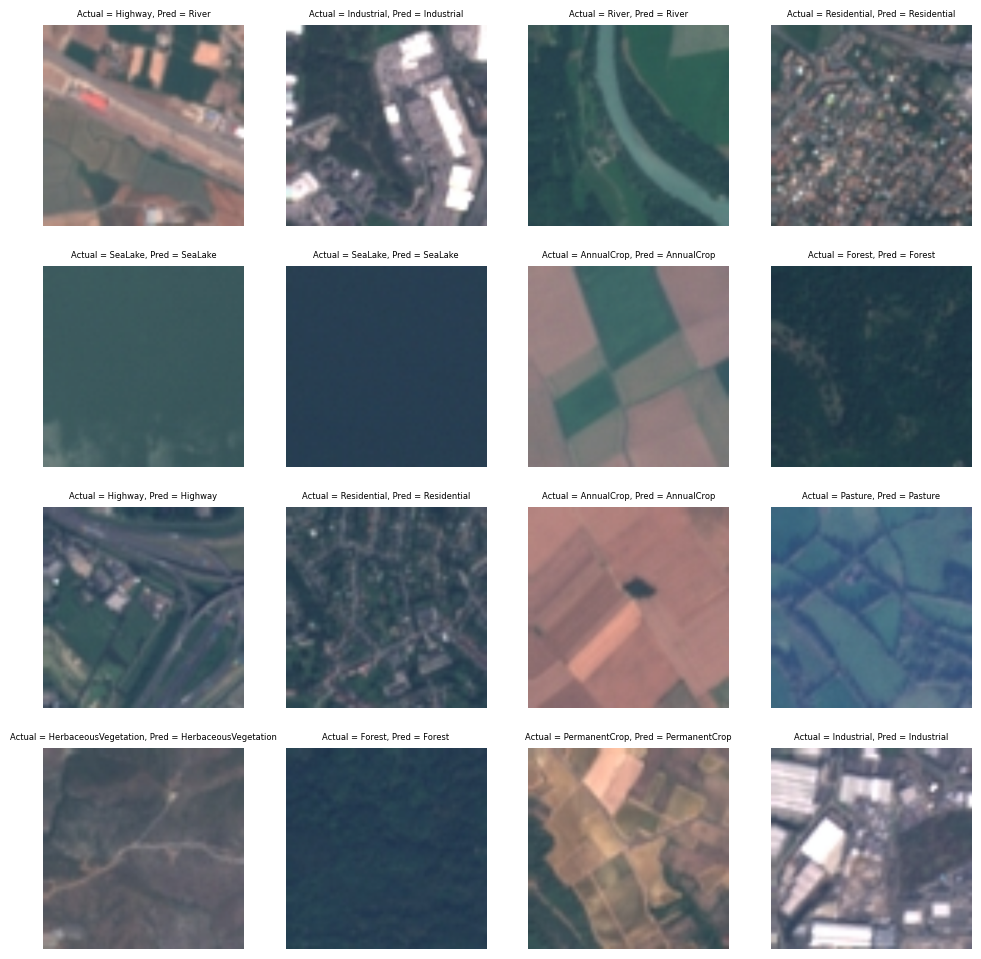

In [31]:
n = 4
fig, axes = plt.subplots(n, n, figsize=(12, 12))

for i in range(n):
  for j in range(n):
    # image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = inputs[i * n + j].cpu().numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = f"Actual = {class_names[labels[i * n + j]]}, Pred = {class_names[preds[i * n + j]]}"
    axes[i, j].imshow(image)
    axes[i, j].set_title(title,fontsize = 6)
    axes[i, j].axis('off')

### Let's try another model

In [32]:
model = models.vgg19(models.VGG19_Weights.IMAGENET1K_V1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.5MB/s]


In [34]:
model = model.to(device)

In [35]:
torchsummary.summary(model,input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [36]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [37]:
model.classifier


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [38]:
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features,len(dataset.classes))

In [39]:
model = model.to(device)

In [40]:
torchsummary.summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Let's train for 10 epochs (all weights trainable, not only final layer)

In [ ]:
best_model_vgg = fit(model = model,
                 train_loader = train_loader,
                 val_loader = val_loader,
                 n_epochs = epochs,
                 lr = lr,
                 criterion = criterion,
                 optimizer = optimizer
                 )

Epoch : 1


 51%|█████     | 605/1182 [02:50<02:42,  3.56it/s]

In [ ]:
test_loss, _ = evaluate(best_model_vgg, test_loader, criterion, phase="test")

This is terribly poor. Let's see how predictions look like.

In [ ]:
inputs, labels = next(iter(test_loader))

inputs = inputs.to(device)
labels = labels.to(device)

with torch.set_grad_enabled(False):
  outputs = best_model_vgg(inputs)
  loss = criterion(outputs, labels)
  _, preds = torch.max(outputs, 1)

In [ ]:
n = 4
fig, axes = plt.subplots(n, n, figsize=(12, 12))

for i in range(n):
  for j in range(n):
    # image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = inputs[i * n + j].cpu().numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = f"Actual = {class_names[labels[i * n + j]]}, Pred = {class_names[preds[i * n + j]]}"
    axes[i, j].imshow(image)
    axes[i, j].set_title(title,fontsize = 6)
    axes[i, j].axis('off')

Now let's try by only changing last layer weights in VGG19

In [ ]:
model = models.vgg19(models.VGG19_Weights.IMAGENET1K_V1)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model = model.to(device)

In [ ]:
torchsummary.summary(model,(3,224,224))

In [ ]:
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features,len(dataset.classes))

In [ ]:
model = model.to(device)

In [ ]:
torchsummary.summary(model,(3,224,224))

In [ ]:
best_model_vgg_last_layer_wts_only = fit(model = model,
                                         train_loader = train_loader,
                                         val_loader = val_loader,
                                         n_epochs = epochs,
                                         lr = lr,
                                         criterion = criterion,
                                         optimizer = optimizer)

Epoch : 1


100%|██████████| 1182/1182 [00:25<00:00, 45.94it/s]


Train loss : 2.34;Accuracy : 10.40


100%|██████████| 254/254 [00:05<00:00, 49.00it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 2


100%|██████████| 1182/1182 [00:24<00:00, 48.02it/s]


Train loss : 2.34;Accuracy : 10.53


100%|██████████| 254/254 [00:05<00:00, 49.27it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 3


100%|██████████| 1182/1182 [00:25<00:00, 45.58it/s]


Train loss : 2.34;Accuracy : 10.38


100%|██████████| 254/254 [00:05<00:00, 49.19it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 4


100%|██████████| 1182/1182 [00:24<00:00, 47.82it/s]


Train loss : 2.34;Accuracy : 10.34


100%|██████████| 254/254 [00:05<00:00, 48.91it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 5


100%|██████████| 1182/1182 [00:26<00:00, 44.58it/s]


Train loss : 2.34;Accuracy : 10.48


100%|██████████| 254/254 [00:05<00:00, 49.63it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 6


100%|██████████| 1182/1182 [00:24<00:00, 47.29it/s]


Train loss : 2.34;Accuracy : 10.17


100%|██████████| 254/254 [00:05<00:00, 48.82it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 7


100%|██████████| 1182/1182 [00:27<00:00, 43.58it/s]


Train loss : 2.34;Accuracy : 10.39


100%|██████████| 254/254 [00:05<00:00, 49.30it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 8


100%|██████████| 1182/1182 [00:25<00:00, 46.91it/s]


Train loss : 2.34;Accuracy : 10.31


100%|██████████| 254/254 [00:05<00:00, 48.18it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 9


100%|██████████| 1182/1182 [00:25<00:00, 47.07it/s]


Train loss : 2.34;Accuracy : 10.23


100%|██████████| 254/254 [00:05<00:00, 48.41it/s]


Val Loss = 2.32; Accuracy = 8.42
Epoch : 10


100%|██████████| 1182/1182 [00:27<00:00, 43.34it/s]


Train loss : 2.34;Accuracy : 10.38


100%|██████████| 254/254 [00:05<00:00, 48.75it/s]

Val Loss = 2.32; Accuracy = 8.42


In [ ]:
test_loss, _ = evaluate(best_model_vgg_last_layer_wts_only, test_loader, criterion, phase="test")

100%|██████████| 254/254 [00:05<00:00, 48.58it/s]

Test Loss = 2.32; Accuracy = 8.77


In [ ]:
inputs, labels = next(iter(test_loader))

inputs = inputs.to(device)
labels = labels.to(device)

with torch.set_grad_enabled(False):
  outputs = best_model_vgg_last_layer_wts_only(inputs)
  loss = criterion(outputs, labels)
  _, preds = torch.max(outputs, 1)

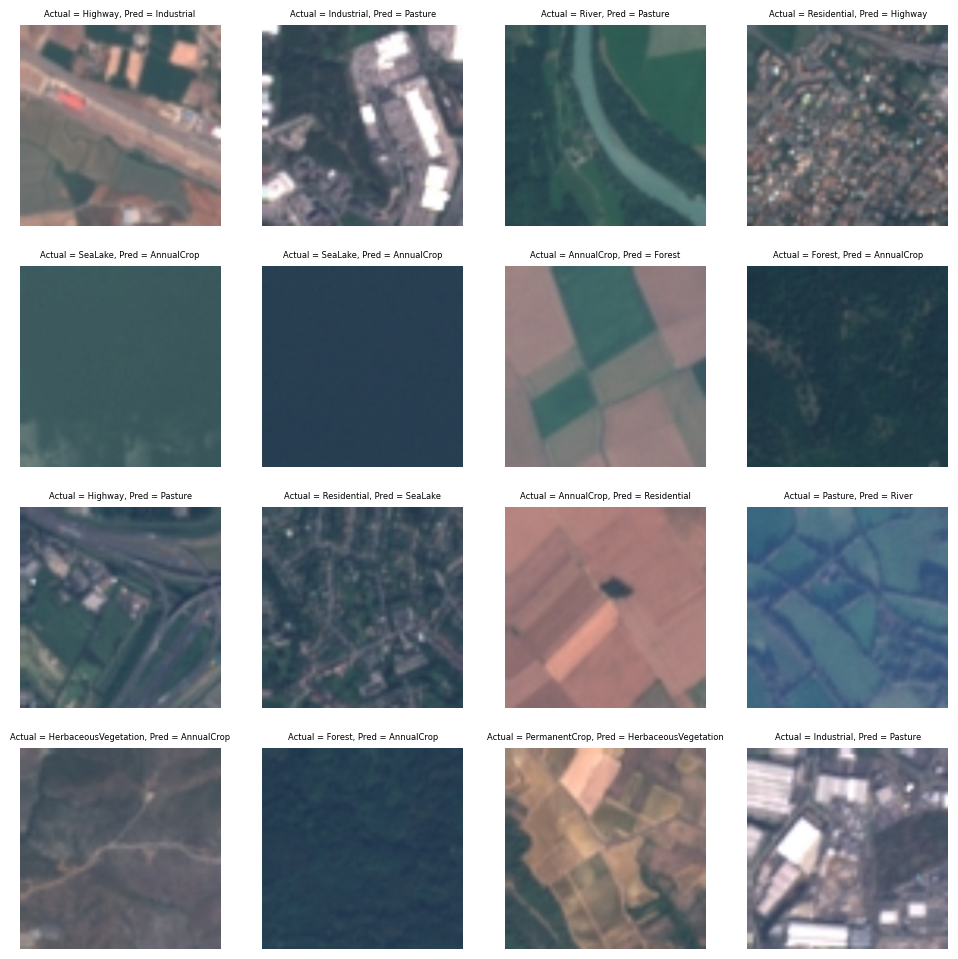

In [ ]:
n = 4
fig, axes = plt.subplots(n, n, figsize=(12, 12))

for i in range(n):
  for j in range(n):
    # image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = inputs[i * n + j].cpu().numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = f"Actual = {class_names[labels[i * n + j]]}, Pred = {class_names[preds[i * n + j]]}"
    axes[i, j].imshow(image)
    axes[i, j].set_title(title,fontsize = 6)
    axes[i, j].axis('off')

Looks like VGG is not doing a good job on the given data.

**Conclusion**:
1. We tried 2 different pretrained models in this notebook:
  * EfficientNet (all weights trainable, 10 epochs) did a good job on the test set (~95% accuracy) whereas
  * VGG had quite poor performance (for both strategies : all weights trainable, only last layer trainable)


3. EfficientNet is comparable to ResNet50 in test set performance, whereas VGG19 does not seem to do a good job on the given data.